In [1]:
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import APSIMGraphHelpers as AGH
import GraphHelpers as GH
import matplotlib.dates as mdates
import MathsUtilities as MUte
import sqlite3
import warnings

In [2]:
warnings.filterwarnings('ignore',category=pd.errors.PerformanceWarning)

In [3]:
Colors = {1:'#000000',
2:'#E69F00',
3:'#56B4E9',
4:'#009E73',
5:'#F0E442',
6:'#0072B2',
7:'#D55E00',
8:'#CC79A7',
9:'#1F77B4',
10:'#AEC7E8',
11:'#FF7F0E',
12:'#FFBB78',
13:'#2CA02C',
14:'#98DF8A',
15:'#D62728',
16:'#FF9896',
17:'#9467BD',
18:'#C5B0D5',
19:'#8C564B',
20:'#C49C94',
21:'#E377C2',
22:'#F7B6D2',
23:'#7F7F7F',
24:'#C7C7C7',
25:'#BCBD22',
26:'#DBDB8D',
27:'#17BECF',
28:'#9EDAE5'}

Markers = {1: 'o',
 2: '^',
 3: 's',
 4: '*',
 5: '>',
 6: 'v',
 7: '+',
 8: 'X',
 9: '<',
 10: 'p',
 11: '8',
 12: 'd',
 13:'P',
 14:'D',
 15:'o',
 16:'^'}

Lines = {1: '-',
 2: '--',
 3: '-,',
 4: ':',
 5: '-',
 6: '--',
 7: '-,',
 8: ':',
 9: '-',
 10: '--',
 11: '-,',
 12: ':',
 13: '-',
 14: '--',
 15: '-,',
 16: ':'}

In [4]:
MasterfilePath = r'C:\GitHubRepos\ApsimX\Tests\Validation\Wheat\Wheat.db'

In [5]:
con = sqlite3.connect(MasterfilePath)
Simulations = pd.read_sql("Select * from _Simulations",con)
con.close()
Simulations.set_index('ID',inplace=True)
Simulations.sort_index(inplace=True)
Simulations.sort_index(inplace=True, axis=1)

In [135]:
con = sqlite3.connect(MasterfilePath)
_Factors = pd.read_sql("Select * from _Factors", con)
con.close()

In [136]:
_Factors

,CheckpointID,SimulationID,ExperimentName,FolderName,FactorName,FactorValue
0,1,1,APS26,SE Queensland,NRate,0
1,1,1,APS26,SE Queensland,Water,Dry
2,1,4,APS26,SE Queensland,NRate,80
3,1,4,APS26,SE Queensland,Water,Wet
4,1,2,APS26,SE Queensland,NRate,40
...,...,...,...,...,...,...
13334,1,1471,FAR SAC W20-05-1,Millicent,Cv,Trojan
13335,1,1475,FAR SAC W20-05-1,Millicent,Grazed,GS32-33
13336,1,1475,FAR SAC W20-05-1,Millicent,Cv,Trojan
13337,1,1474,FAR SAC W20-05-1,Millicent,Grazed,Lax


In [6]:
SensibilityFolders = ['CO2AndTranspirationEfficiency',
'CO2AndTemperatureInteractions',
'ProteinAccumulation',
'LeafAppearance',
'TerminalWaterStress',
'DetailedDynamics']

In [7]:
con = sqlite3.connect(MasterfilePath)
HarvestPred = pd.read_sql("Select * from HarvestReport",con).dropna(axis=1,how='all')
con.close()
HarvestPred.loc[:,'SimulationName'] = [Simulations.loc[x,'Name'] for x in HarvestPred.SimulationID]
HarvestPred.set_index(['SimulationName','Clock.Today'],drop=False,inplace=True)
HarvestPred.sort_index(inplace=True)
HarvestPred.sort_index(inplace=True,axis=1)

# Filter outputs from sensibility tests
validationFilter = [x not in SensibilityFolders for x in HarvestPred.FolderName]
HarvestPred = HarvestPred.loc[validationFilter,:].copy()
HarvestPred.dropna(how='all',axis=1,inplace=True)
HarvestPred.loc[:,'Wheat.SowingData.Cultivar'] = [x.title() for x in HarvestPred.loc[:,'Wheat.SowingData.Cultivar']]
validationFilter = [x not in SensibilityFolders for x in HarvestPred.FolderName]
HarvestPred = HarvestPred.loc[validationFilter,:].copy()
HarvestPred.dropna(how='all',axis=1,inplace=True)
HarvestPred.sort_index(inplace=True)
HarvestPred.sort_index(inplace=True,axis=1)

# Replace Experiment with values that have had folder name pathed in where no experiment is present
HarvestPred.loc[[x is None for x in HarvestPred.Experiment],'Experiment'] = HarvestPred.loc[[x is None for x in HarvestPred.Experiment],'FolderName']

In [8]:
con = sqlite3.connect(MasterfilePath)
DailyPred = pd.read_sql("Select * from DailyReport",con)
con.close()
DailyPred.loc[:,'SimulationName'] = [Simulations.loc[x,'Name'] for x in DailyPred.SimulationID]
DailyPred.set_index(['SimulationName','Clock.Today'],drop=False,inplace=True)
DailyPred.sort_index(inplace=True)
DailyPred.sort_index(inplace=True,axis=1)
validationFilter = [x not in SensibilityFolders for x in DailyPred.FolderName]
DailyPred = DailyPred.loc[validationFilter,:].copy()
DailyPred.dropna(how='all',axis=1,inplace=True)
# Replace Experiment with values that have had folder name path in where no experiment is present
DailyPred.loc[:,'Experiment'] = [HarvestPred.loc[x,'Experiment'] for x in DailyPred.index.get_level_values(0)]
DailyPred.loc[:,'Wheat.SowingData.Population'] = [HarvestPred.loc[x,'Wheat.SowingData.Population'].values[0] for x in DailyPred.index.get_level_values(0)]

## Join NDVI data into daily obs
con = sqlite3.connect(MasterfilePath)
NDVIPred = pd.read_sql("Select * from NDVIDailyReport",con)
con.close()
NDVIPred.loc[:,'SimulationName'] = [Simulations.loc[x,'Name'] for x in NDVIPred.SimulationID]
NDVIPred.set_index(['SimulationName','Clock.Today'],drop=False,inplace=True)
NDVIPred.sort_index(inplace=True)
NDVIPred.sort_index(inplace=True,axis=1)

validationFilter = [x not in SensibilityFolders for x in NDVIPred.FolderName]
NDVIPred = NDVIPred.loc[validationFilter,:].copy()
NDVIPred.dropna(how='all',axis=1,inplace=True)
##Join NDVI predictions in with others 
for i in NDVIPred.index:
    DailyPred.loc[i,'NDVIModel.Script.NDVI'] = NDVIPred.loc[i,'NDVIModel.Script.NDVI']

In [9]:
## Join NDVI data into daily obs
con = sqlite3.connect(MasterfilePath)
NDVIPred = pd.read_sql("Select * from NDVIDailyReport",con)
con.close()
NDVIPred.loc[:,'SimulationName'] = [Simulations.loc[x,'Name'] for x in NDVIPred.SimulationID]
NDVIPred.set_index(['SimulationName','Clock.Today'],drop=False,inplace=True)
NDVIPred.sort_index(inplace=True)
NDVIPred.sort_index(inplace=True,axis=1)

validationFilter = [x not in SensibilityFolders for x in NDVIPred.FolderName]
NDVIPred = NDVIPred.loc[validationFilter,:].copy()
NDVIPred.dropna(how='all',axis=1,inplace=True)
##Join NDVI predictions in with others 
for i in NDVIPred.index:
    DailyPred.loc[i,'NDVIModel.Script.NDVI'] = NDVIPred.loc[i,'NDVIModel.Script.NDVI']

NDVIPred.sort_index(inplace=True)
NDVIPred.sort_index(inplace=True,axis=1)

In [110]:
SowIndices = ['IWeather.Latitude',
    'IWeather.Longitude',
    'LocationInfo.Script.Country',
    'LocationInfo.Script.Region',
    'LocationInfo.Script.State',
    'Wheat.SowingData.Cultivar',
    'Experiment',
    'FolderName']

def getValue(ind,var,HarvestPred):
    try:
        return HarvestPred.loc[ind,var].values[0]
    except:
        return ""

con = sqlite3.connect(MasterfilePath)
Observed = pd.read_sql("Select * from Observed",con).dropna(axis=1,how='all')
con.close()
Observed.loc[:,'SimulationName'] = [Simulations.loc[x,'Name'] for x in Observed.SimulationID]
Observed.set_index(['SimulationName','Clock.Today'],drop=False,inplace=True)
Observed.sort_index(inplace=True)
Observed.sort_index(inplace=True,axis=1)
for s in SowIndices:
    Observed.loc[:,s] = [getValue(x,s,HarvestPred) for x in Observed.index.get_level_values(0)]

def subtract(a,b):
    if np.isnan(b):
        b = 0
    return a - b

Observed.loc[:,'Wheat.AboveGroundLive.Wt'] = [subtract(Observed.iloc[x,:]['Wheat.AboveGround.Wt'], Observed.iloc[x,:]['Wheat.Leaf.Dead.Wt']) for x in range(Observed.index.size)]

In [111]:
MasterIndexVars = ['Clock.Today',
'IWeather.MaxT',
'IWeather.MinT',
'IWeather.Radn',
'Wheat.DaysAfterSowing',
'Wheat.Phenology.AccumulatedTT',
'Wheat.Phenology.PTQ',
'Wheat.Phenology.CurrentPhaseName',
'Wheat.Phenology.CurrentStageName',
'Wheat.Phenology.Stage']

for iv in MasterIndexVars:
    Observed.loc[:,iv] = DailyPred.reindex(Observed.index).loc[:,iv]    

In [112]:
MasterIndexVarsHarv = ['SimulationID','SimulationName']

def getvar(x,iv):
    try:
        Observed.loc[x,iv] = HarvestPred.reindex(Observed.index).loc[x,iv]  
    except:
        do = 'Nothing'
        
for iv in MasterIndexVarsHarv:
    Observed.loc[:,iv] = HarvestPred.reindex(Observed.index).loc[:,iv]  

def setvar(x):
    if np.isnan(Observed.loc[x,'Wheat.Population'].values[0]):
        try:
            if ~np.isnan(HarvestPred.loc[x,'Wheat.SowingData.Population'].values[0]):
                Observed.loc[x,'Wheat.Population'] = HarvestPred.loc[x,'Wheat.SowingData.Population'].values[0]
        except:
            try:
                if ~np.isnan(HarvestPred.loc[x[0],'Wheat.SowingData.Population'].values[0]):
                    Observed.loc[x,'Wheat.Population'] = HarvestPred.loc[x[0],'Wheat.SowingData.Population'].values[0]
            except:
                do = 'Nothing'

for x in Observed.index:
        setvar(x)

Observed.sort_index(inplace=True)
Observed.sort_index(inplace=True,axis=1)

Text(0.5, 0, 'Stem.Wt')

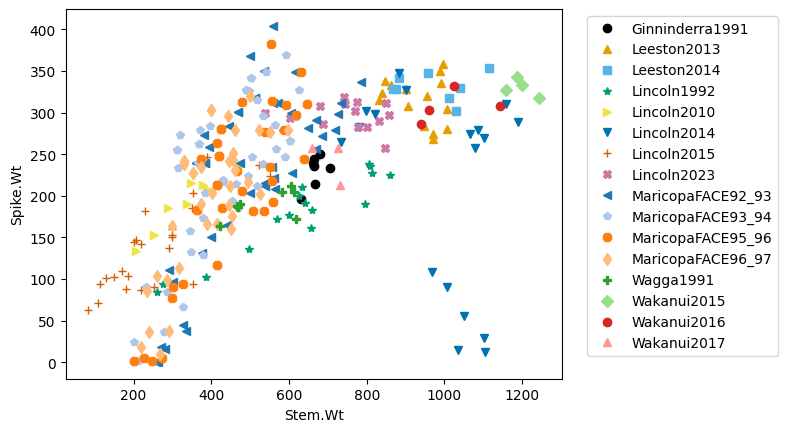

In [115]:
vars = ['Wheat.Spike.Wt','Wheat.Stem.Wt']+['Experiment']
data = Observed.loc[:,vars].dropna()
Experiments = data.Experiment.drop_duplicates()
cpos=1
mpos=1
for e in Experiments:
    exData = data.loc[data.Experiment == e,:]
    plt.plot(exData.loc[:,vars[1]],exData.loc[:,vars[0]],Markers[mpos],color=Colors[cpos],label=e)
    cpos+=1
    mpos+=1
plt.legend(bbox_to_anchor=(1.45, 1),numpoints=1)
plt.ylabel('Spike.Wt')
plt.xlabel('Stem.Wt')

In [114]:
a = 'Wheat.Leaf.StemPopulation'
b = 'Wheat.Leaf.StemNumberPerPlant'
c = 'Wheat.Population'

def FillDataGap(set):
    a,b,c = set.values[0],set.values[1],set.values[2]
    if sum(np.isnan([a,b,c])) == 0:
        return [a,b,c]
    if sum(np.isnan([a,b,c])) > 1:
        return [a,b,c]
    if sum(np.isnan([a,b,c])) == 1:
        if np.isnan(a):
            a = b * c
        if np.isnan(b):
            b = a/c
        if np.isnan(c):
            c = a/b
        return [a,b,c]
    
Observed.sort_index(axis=1,inplace=True)
Observed.sort_index(axis=1,inplace=True)
Observed.loc[:,[a,b,c]] = [FillDataGap(Observed.iloc[x,:][[a,b,c]]) for x in range(Observed.index.size)]

Text(0.5, 0, 'Phenology.Stage')

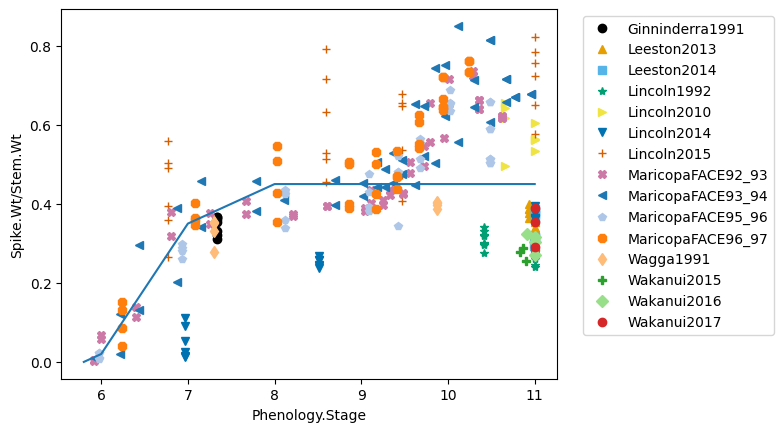

In [14]:
vars = ['Wheat.Spike.Wt','Wheat.Phenology.Stage','Wheat.Stem.Wt']+['Experiment']
data = Observed.loc[:,vars].dropna()
Experiments = data.Experiment.drop_duplicates()
cpos=1
mpos=1
for e in Experiments:
    exData = data.loc[data.Experiment == e,:]
    plt.plot(exData.loc[:,'Wheat.Phenology.Stage'],exData.loc[:,'Wheat.Spike.Wt']/exData.loc[:,'Wheat.Stem.Wt'],Markers[mpos],color=Colors[cpos],label=e)
    cpos+=1
    mpos+=1
plt.legend(bbox_to_anchor=(1.45, 1),numpoints=1)
plt.plot([5.8,6.0,7.0,8.0,11.0],
         [0.0,.02,.35,.45,.45],'-')
plt.ylabel('Spike.Wt/Stem.Wt')
plt.xlabel('Phenology.Stage')

Text(0.5, 0, 'Phenology.Stage')

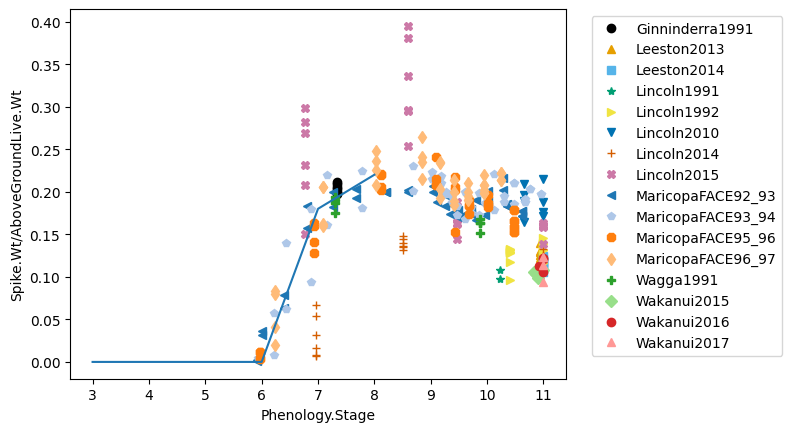

In [15]:
vars = ['Wheat.AboveGroundLive.Wt','Wheat.Phenology.Stage','Wheat.Spike.Wt']+['Experiment']
data = Observed.loc[:,vars].dropna()
Experiments = data.Experiment.drop_duplicates()
cpos=1
mpos=1
for e in Experiments:
    exData = data.loc[data.Experiment == e,:]
    plt.plot(exData.loc[:,'Wheat.Phenology.Stage'],exData.loc[:,'Wheat.Spike.Wt']/exData.loc[:,'Wheat.AboveGroundLive.Wt'],Markers[mpos],color=Colors[cpos],label=e)
    cpos+=1
    mpos+=1
    if mpos > 16:
        mpos=1
plt.legend(bbox_to_anchor=(1.45, 1),numpoints=1)
plt.plot([3.0,6,7.0,8.0,],
         [0,0,.18,.22],'-')
plt.ylabel('Spike.Wt/AboveGroundLive.Wt')
plt.xlabel('Phenology.Stage')


(0.0, 0.9)

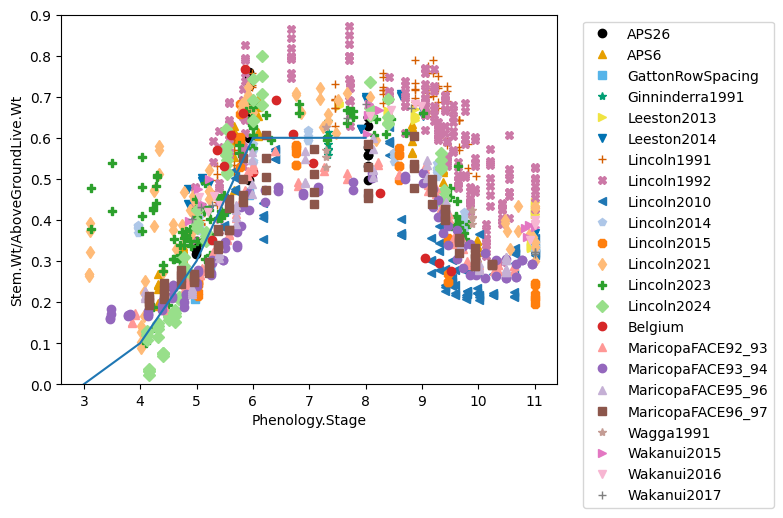

In [17]:
vars = ['Wheat.AboveGroundLive.Wt','Wheat.Phenology.Stage','Wheat.Stem.Wt']+['Experiment']
data = Observed.loc[:,vars].dropna()
Experiments = data.Experiment.drop_duplicates()
cpos=1
mpos=1
for e in Experiments:
    exData = data.loc[data.Experiment == e,:]
    plt.plot(exData.loc[:,'Wheat.Phenology.Stage'],exData.loc[:,'Wheat.Stem.Wt']/exData.loc[:,'Wheat.AboveGroundLive.Wt'],Markers[mpos],color=Colors[cpos],label=e)
    cpos+=1
    mpos+=1
    if mpos > 16:
        mpos=1
plt.legend(bbox_to_anchor=(1.45, 1),numpoints=1)
plt.plot([3.0,4.0,5.0,6.0,8.0],
         [0.0,.1,.3,.6,.6],'-')
plt.ylabel('Stem.Wt/AboveGroundLive.Wt')
plt.xlabel('Phenology.Stage')
plt.ylim(0,.9)

(0.0, 1.0)

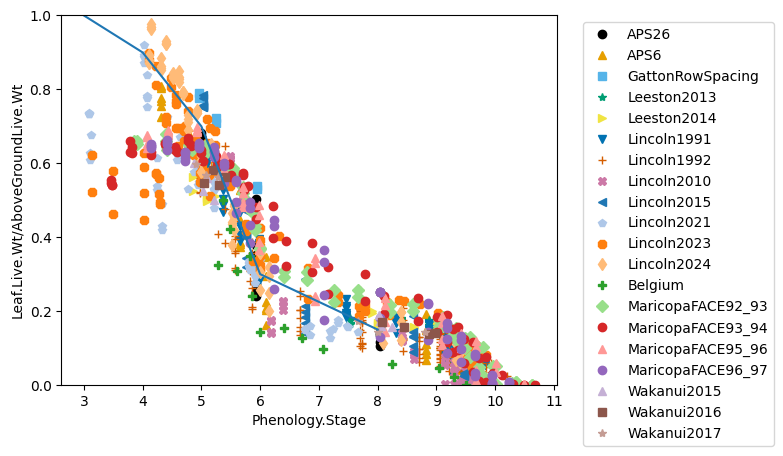

In [18]:
vars = ['Wheat.AboveGroundLive.Wt','Wheat.Phenology.Stage','Wheat.Leaf.Live.Wt']+['Experiment']
data = Observed.loc[:,vars].dropna()
Experiments = data.Experiment.drop_duplicates()
cpos=1
mpos=1
for e in Experiments:
    exData = data.loc[data.Experiment == e,:]
    plt.plot(exData.loc[:,'Wheat.Phenology.Stage'],exData.loc[:,'Wheat.Leaf.Live.Wt']/exData.loc[:,'Wheat.AboveGroundLive.Wt'],Markers[mpos],color=Colors[cpos],label=e)
    cpos+=1
    mpos+=1
    if mpos > 16:
        mpos=1
plt.legend(bbox_to_anchor=(1.45, 1),numpoints=1)
plt.plot([3.0,4.0,5.0,6.0,8.0],
         [1,.9,.7,.3,.15],'-')
plt.ylabel('Leaf.Live.Wt/AboveGroundLive.Wt')
plt.xlabel('Phenology.Stage')
plt.ylim(0,1)

Text(0.5, 0, 'Phenology.Stage')

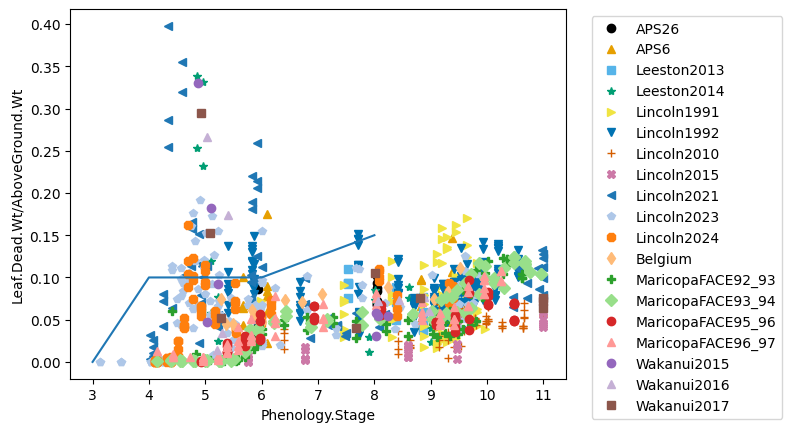

In [19]:
vars = ['Wheat.AboveGround.Wt','Wheat.Phenology.Stage','Wheat.Leaf.Dead.Wt']+['Experiment']
data = Observed.loc[:,vars].dropna()
Experiments = data.Experiment.drop_duplicates()
cpos=1
mpos=1
for e in Experiments:
    exData = data.loc[data.Experiment == e,:]
    plt.plot(exData.loc[:,'Wheat.Phenology.Stage'],exData.loc[:,'Wheat.Leaf.Dead.Wt']/exData.loc[:,'Wheat.AboveGround.Wt'],Markers[mpos],color=Colors[cpos],label=e)
    cpos+=1
    mpos+=1
    if mpos > 16:
        mpos=1
plt.legend(bbox_to_anchor=(1.45, 1),numpoints=1)
plt.plot([3.0,4.0,5.0,6.0,8.0],
         [0,.1,.1,.1,.15],'-')
plt.ylabel('Leaf.Dead.Wt/AboveGround.Wt')
plt.xlabel('Phenology.Stage')


Text(0.5, 0, 'Phenology.Stage')

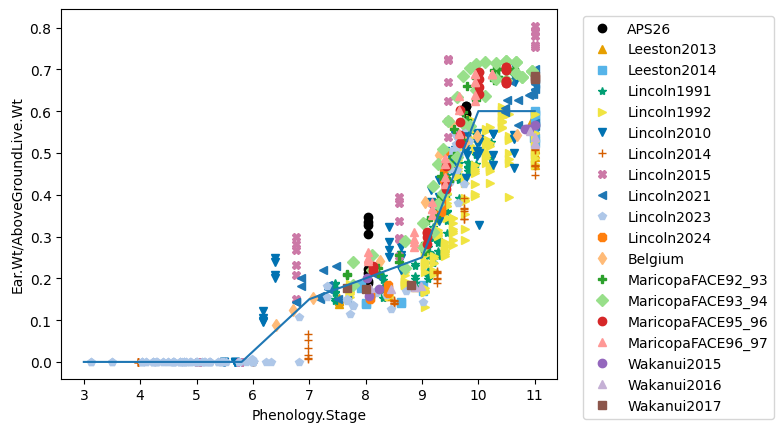

In [20]:
vars = ['Wheat.AboveGroundLive.Wt','Wheat.Phenology.Stage','Wheat.Ear.Wt']+['Experiment']
data = Observed.loc[:,vars].dropna()
Experiments = data.Experiment.drop_duplicates()
cpos=1
mpos=1
for e in Experiments:
    exData = data.loc[data.Experiment == e,:]
    plt.plot(exData.loc[:,'Wheat.Phenology.Stage'],exData.loc[:,'Wheat.Ear.Wt']/exData.loc[:,'Wheat.AboveGroundLive.Wt'],Markers[mpos],color=Colors[cpos],label=e)
    cpos+=1
    mpos+=1
    if mpos > 16:
        mpos=1
plt.legend(bbox_to_anchor=(1.45, 1),numpoints=1)
plt.plot([3.0,5.8,7.0,8.0,9.0,10,11],
         [0,0,.15,.2,.25,0.6,0.6],'-')
plt.ylabel('Ear.Wt/AboveGroundLive.Wt')
plt.xlabel('Phenology.Stage')


Text(0.5, 0, 'Phenology.Stage')

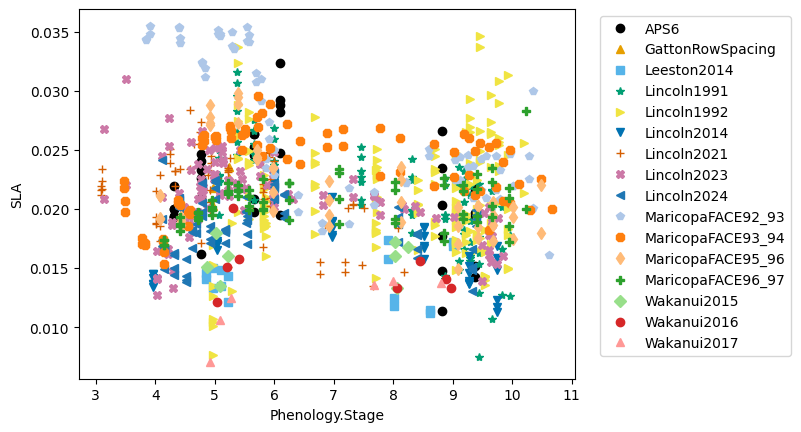

In [21]:
vars = ['Wheat.Leaf.SpecificAreaCanopy','Wheat.Phenology.Stage','IWeather.MaxT']+['Experiment']
data = Observed.loc[:,vars].dropna()
Experiments = data.Experiment.drop_duplicates()
cpos=1
mpos=1
for e in Experiments:
    exData = data.loc[data.Experiment == e,:]
    plt.plot(exData.loc[:,'Wheat.Phenology.Stage'],exData.loc[:,'Wheat.Leaf.SpecificAreaCanopy'],Markers[mpos],color=Colors[cpos],label=e)
    cpos+=1
    mpos+=1
plt.legend(bbox_to_anchor=(1.45, 1),numpoints=1)
plt.ylabel('SLA')
plt.xlabel('Phenology.Stage')

Text(0.5, 0, 'Phenology.Stage')

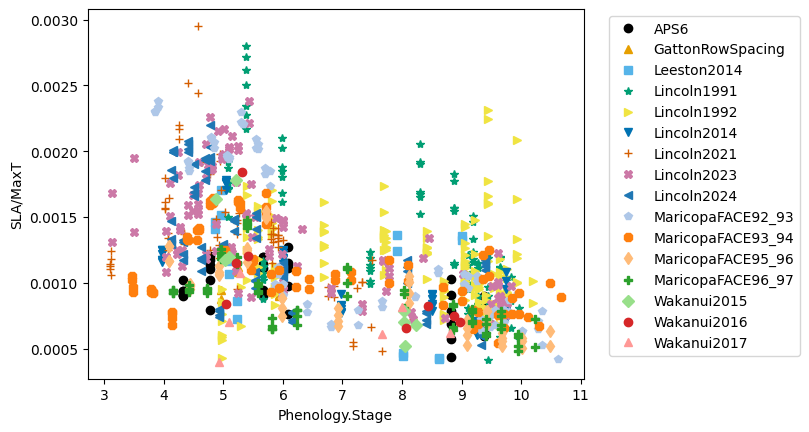

In [22]:
vars = ['Wheat.Leaf.SpecificAreaCanopy','Wheat.Phenology.Stage','IWeather.MaxT']+['Experiment']
data = Observed.loc[:,vars].dropna()
Experiments = data.Experiment.drop_duplicates()
cpos=1
mpos=1
for e in Experiments:
    exData = data.loc[data.Experiment == e,:]
    plt.plot(exData.loc[:,'Wheat.Phenology.Stage'],exData.loc[:,'Wheat.Leaf.SpecificAreaCanopy']/exData.loc[:,'IWeather.MaxT'],Markers[mpos],color=Colors[cpos],label=e)
    cpos+=1
    mpos+=1
plt.legend(bbox_to_anchor=(1.45, 1),numpoints=1)
plt.ylabel('SLA/MaxT')
plt.xlabel('Phenology.Stage')

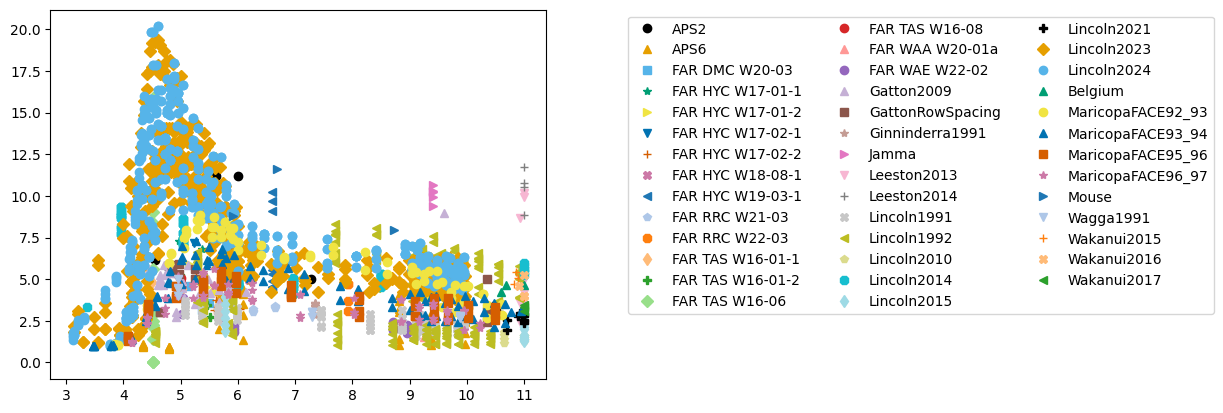

In [108]:
vars = ['Wheat.Leaf.StemNumberPerPlant','Wheat.Phenology.Stage']+['Experiment']
data = Observed.loc[:,vars].dropna()
Experiments = data.Experiment.drop_duplicates()
cpos=1
mpos=1
for e in Experiments:
    exData = data.loc[data.Experiment == e,:]
    plt.plot(exData.loc[:,'Wheat.Phenology.Stage'],exData.loc[:,'Wheat.Leaf.StemNumberPerPlant'],Markers[mpos],color=Colors[cpos],label=e)
    cpos+=1
    mpos+=1
    if mpos>16:
        mpos=1
    if cpos>28:
        cpos=1
plt.legend(bbox_to_anchor=(1.15, 1),numpoints=1,ncols=3)

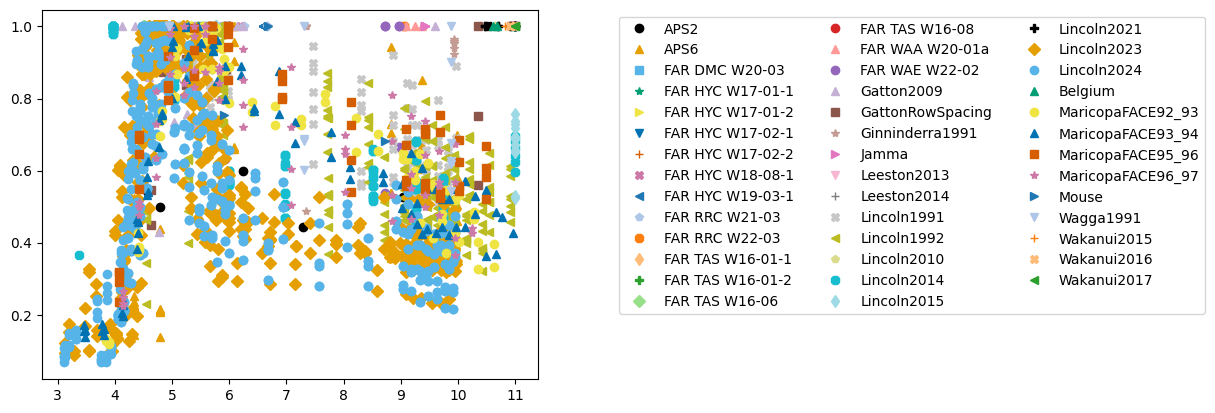

In [26]:
vars = ['Wheat.Leaf.StemNumberPerPlant','Wheat.Phenology.Stage']+['Experiment']
data = Observed.loc[:,vars].dropna()
Experiments = data.Experiment.drop_duplicates()
cpos=1
mpos=1
for e in Experiments:
    exData = data.loc[data.Experiment == e,:]
    sims = exData.index.get_level_values(0).drop_duplicates()
    spos = 0
    for s in sims:
        maxSN = exData.loc[s,'Wheat.Leaf.StemNumberPerPlant'].max()
        if spos == 0:
            plt.plot(exData.loc[s,'Wheat.Phenology.Stage'],exData.loc[s,'Wheat.Leaf.StemNumberPerPlant']/maxSN,Markers[mpos],color=Colors[cpos],label=e)
        else:
            plt.plot(exData.loc[s,'Wheat.Phenology.Stage'],exData.loc[s,'Wheat.Leaf.StemNumberPerPlant']/maxSN,Markers[mpos],color=Colors[cpos])
        spos+=1
    cpos+=1
    mpos+=1
    if mpos>16:
        mpos=1
    if cpos>28:
        cpos=1
plt.legend(bbox_to_anchor=(1.15, 1),numpoints=1,ncols=3)

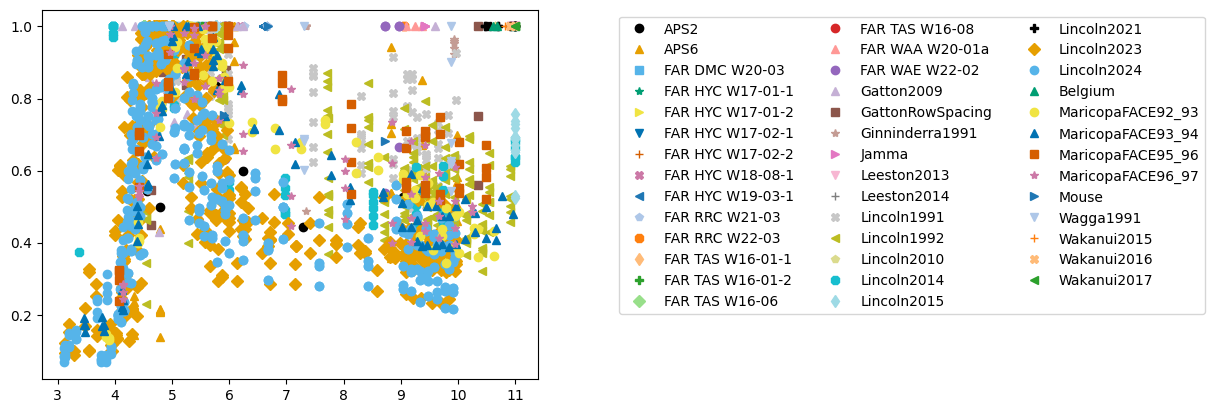

In [34]:
vars = ['Wheat.Leaf.StemPopulation','Wheat.Phenology.Stage']+['Experiment']
data = Observed.loc[:,vars].dropna()
Experiments = data.Experiment.drop_duplicates()
cpos=1
mpos=1
for e in Experiments:
    exData = data.loc[data.Experiment == e,:]
    sims = exData.index.get_level_values(0).drop_duplicates()
    spos = 0
    for s in sims:
        maxSN = exData.loc[s,'Wheat.Leaf.StemPopulation'].max()
        if spos == 0:
            plt.plot(exData.loc[s,'Wheat.Phenology.Stage'],exData.loc[s,'Wheat.Leaf.StemPopulation']/maxSN,Markers[mpos],color=Colors[cpos],label=e)
        else:
            plt.plot(exData.loc[s,'Wheat.Phenology.Stage'],exData.loc[s,'Wheat.Leaf.StemPopulation']/maxSN,Markers[mpos],color=Colors[cpos])
        spos+=1
    cpos+=1
    mpos+=1
    if mpos>16:
        mpos=1
    if cpos>28:
        cpos=1
plt.legend(bbox_to_anchor=(1.15, 1),numpoints=1,ncols=3)

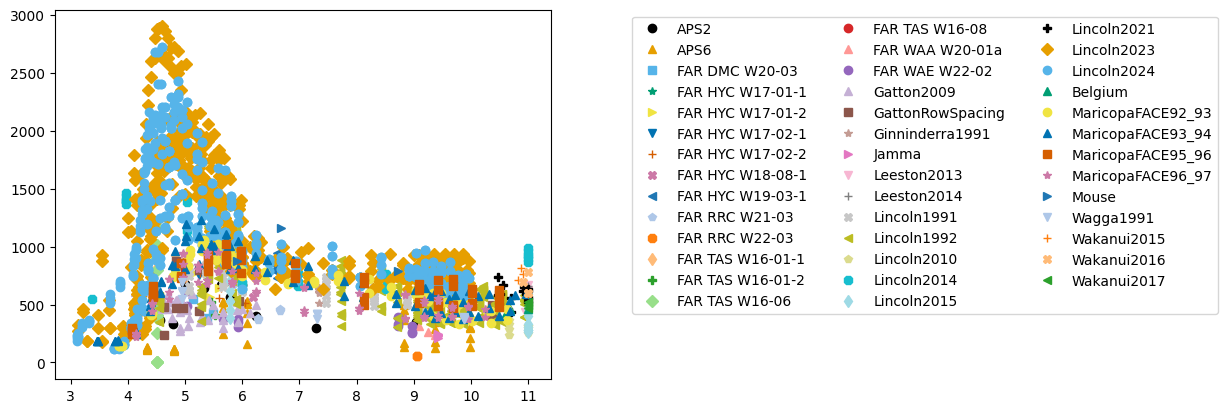

In [27]:
vars = ['Wheat.Leaf.StemPopulation','Wheat.Phenology.Stage']+['Experiment']
data = Observed.loc[:,vars].dropna()
Experiments = data.Experiment.drop_duplicates()
cpos=1
mpos=1
for e in Experiments:
    exData = data.loc[data.Experiment == e,:]
    plt.plot(exData.loc[:,'Wheat.Phenology.Stage'],exData.loc[:,'Wheat.Leaf.StemPopulation'],Markers[mpos],color=Colors[cpos],label=e)
    cpos+=1
    mpos+=1
    if mpos>16:
        mpos=1
    if cpos>28:
        cpos=1
plt.legend(bbox_to_anchor=(1.15, 1),numpoints=1,ncols=3)

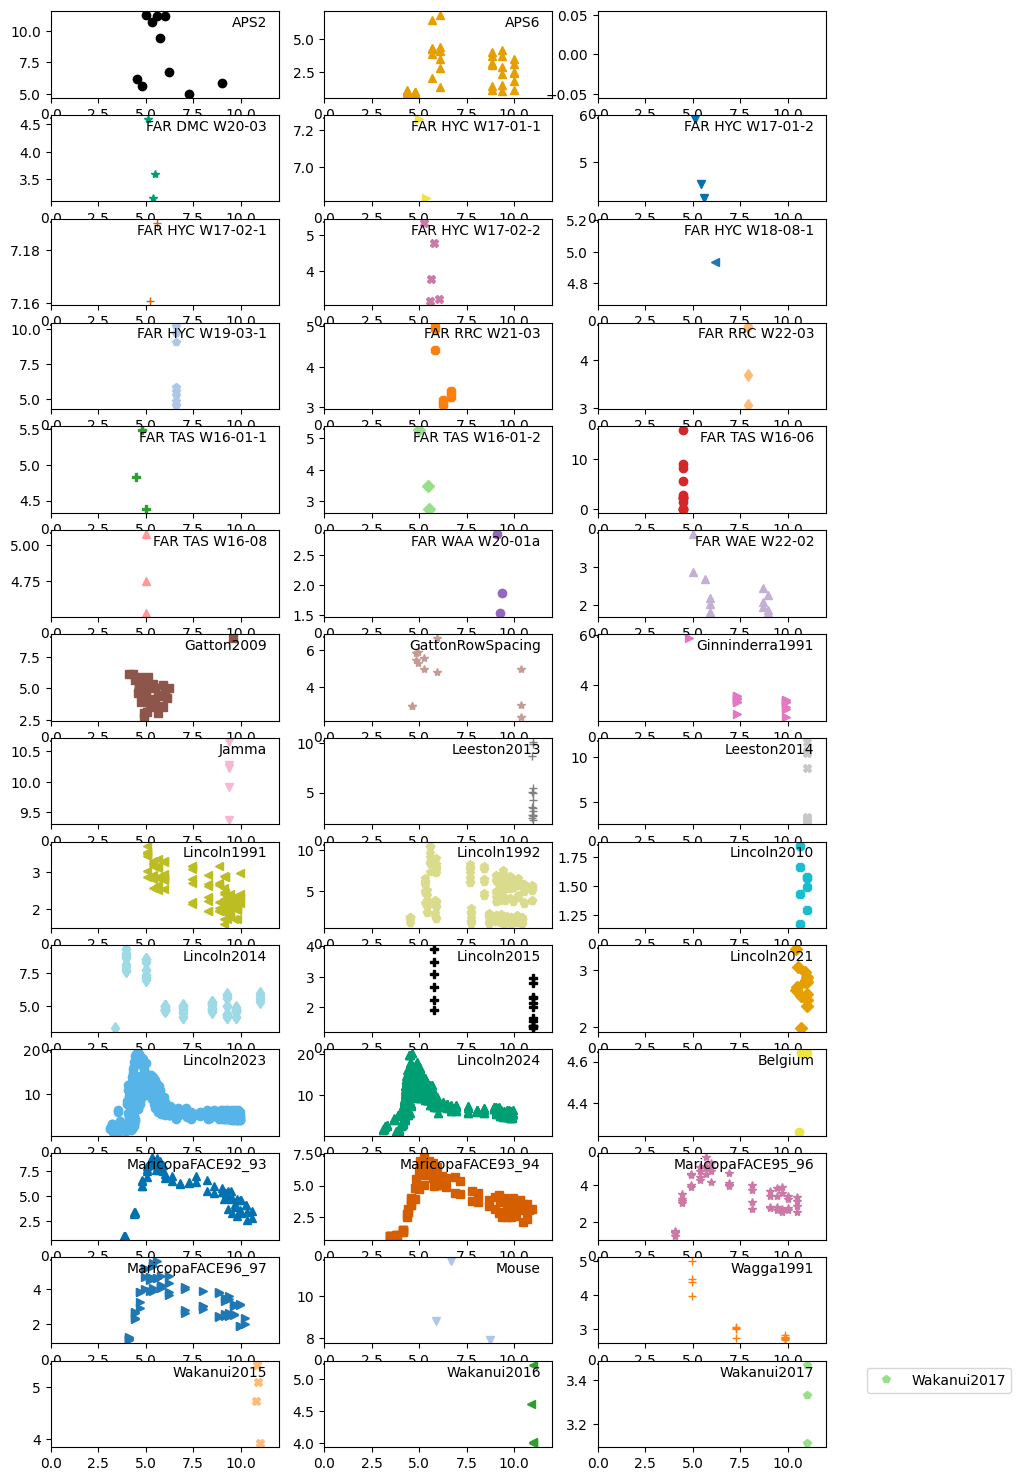

In [124]:
vars = ['Wheat.Leaf.StemPopulation','Wheat.Phenology.Stage','Wheat.Population','Wheat.Phenology.AccumulatedTT','Wheat.Leaf.StemNumberPerPlant']+['Experiment']
data = Observed.loc[:,vars].dropna(subset= ['Wheat.Leaf.StemPopulation','Wheat.Leaf.StemNumberPerPlant'],how='all')
Experiments = data.Experiment.drop_duplicates()
cpos=1
mpos=1
pos=1
graph = plt.figure(figsize=(10,20))
for e in Experiments:
    ax = graph.add_subplot(15,3,pos)
    exData = data.loc[data.Experiment == e,:]
    plt.plot(exData.loc[:,'Wheat.Phenology.Stage'],exData.loc[:,'Wheat.Leaf.StemNumberPerPlant'],Markers[mpos],color=Colors[cpos],label=e)
    plt.text(0.95,0.95,e,transform = ax.transAxes,horizontalalignment='right', verticalalignment='top')
    plt.xlim(0,12)
    cpos+=1
    mpos+=1
    pos+=1               
    if mpos>16:
        mpos=1
    if cpos>28:
        cpos=1
plt.legend(bbox_to_anchor=(1.15, 1),numpoints=1,ncols=3)

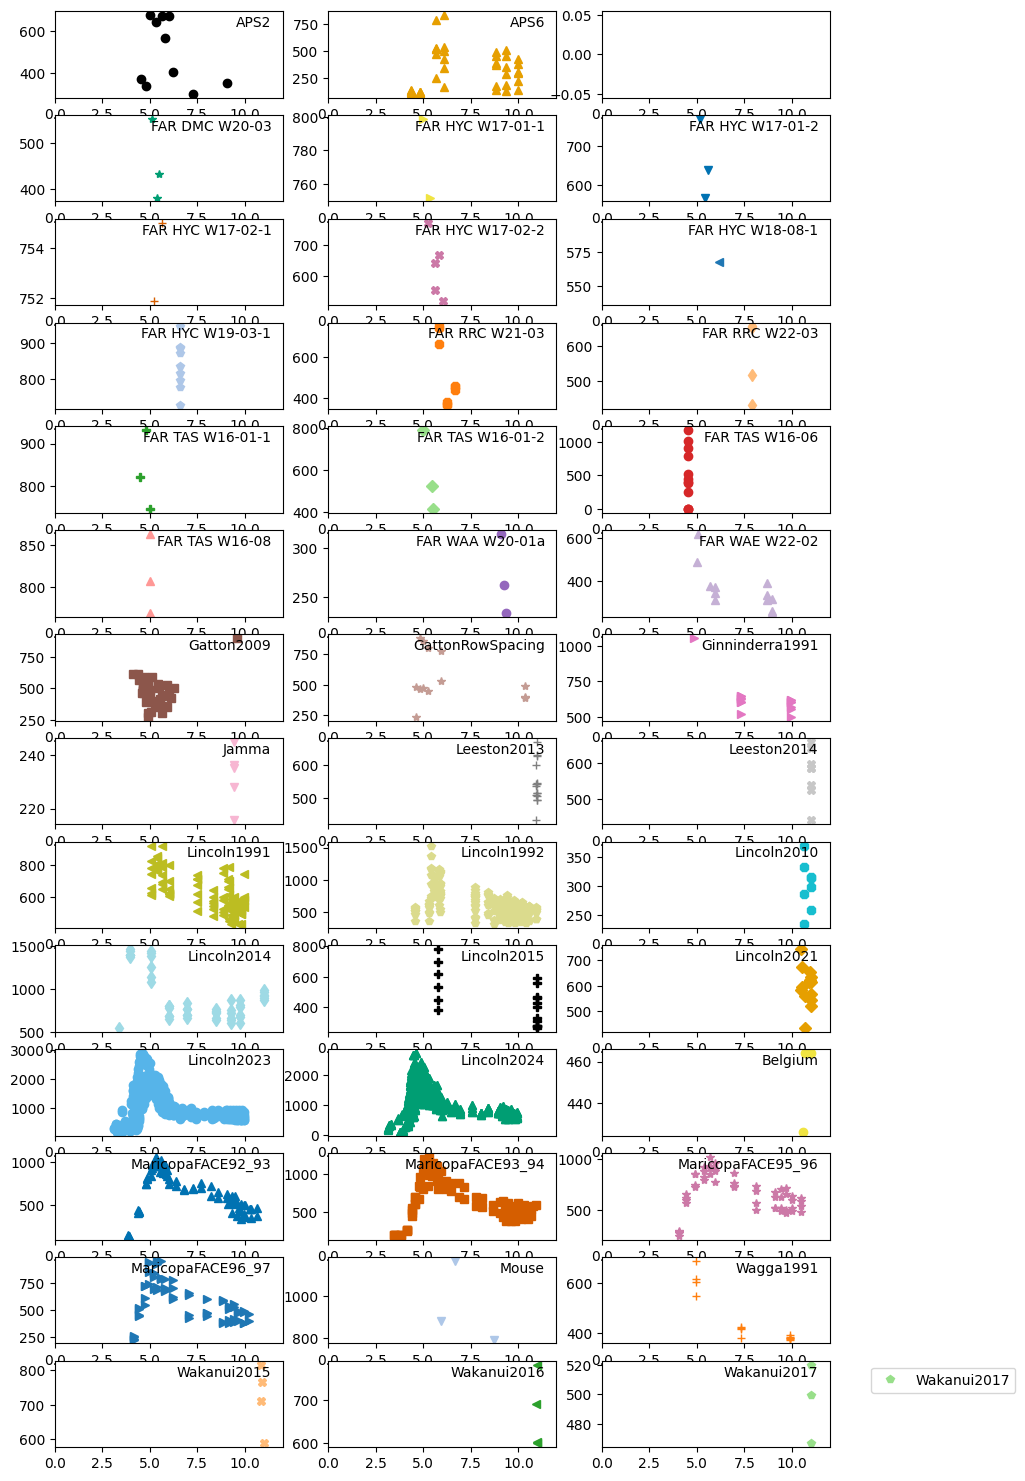

In [123]:
vars = ['Wheat.Leaf.StemPopulation','Wheat.Phenology.Stage','Wheat.Population','Wheat.Phenology.AccumulatedTT','Wheat.Leaf.StemNumberPerPlant']+['Experiment']
data = Observed.loc[:,vars].dropna(subset= ['Wheat.Leaf.StemPopulation','Wheat.Leaf.StemNumberPerPlant'],how='all')
Experiments = data.Experiment.drop_duplicates()
cpos=1
mpos=1
pos=1
graph = plt.figure(figsize=(10,20))
for e in Experiments:
    ax = graph.add_subplot(15,3,pos)
    exData = data.loc[data.Experiment == e,:]
    plt.plot(exData.loc[:,'Wheat.Phenology.Stage'],exData.loc[:,'Wheat.Leaf.StemPopulation'],Markers[mpos],color=Colors[cpos],label=e)
    plt.text(0.95,0.95,e,transform = ax.transAxes,horizontalalignment='right', verticalalignment='top')
    plt.xlim(0,12)
    cpos+=1
    mpos+=1
    pos+=1               
    if mpos>16:
        mpos=1
    if cpos>28:
        cpos=1
plt.legend(bbox_to_anchor=(1.15, 1),numpoints=1,ncols=3)

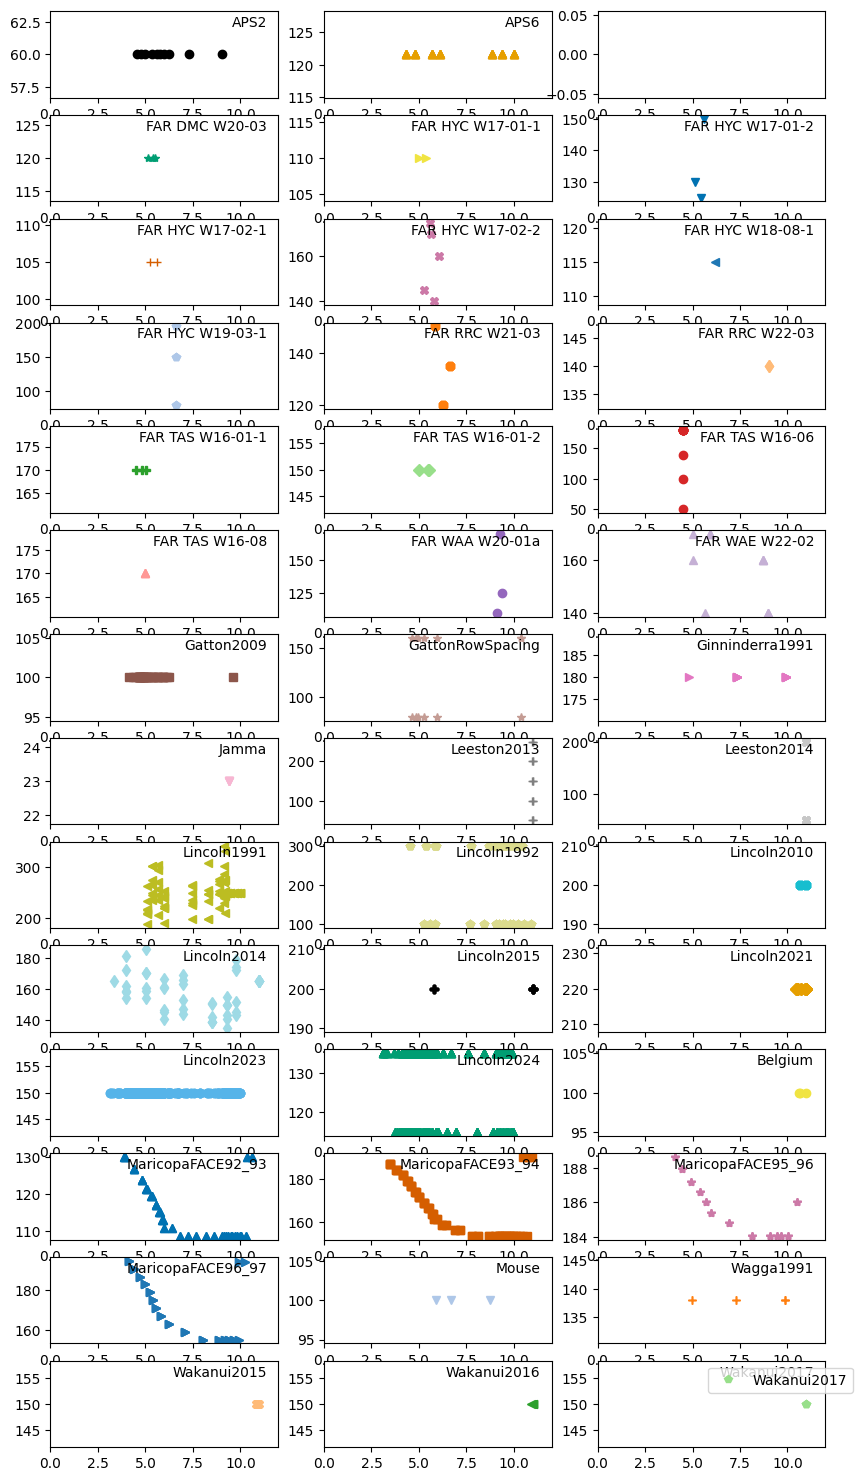

In [30]:
vars = ['Wheat.Leaf.StemPopulation','Wheat.Phenology.Stage','Wheat.Population','Wheat.Phenology.AccumulatedTT','Wheat.Leaf.StemNumberPerPlant']+['Experiment']
data = Observed.loc[:,vars].dropna(subset= ['Wheat.Leaf.StemPopulation','Wheat.Leaf.StemNumberPerPlant'],how='all')
Experiments = data.Experiment.drop_duplicates()
cpos=1
mpos=1
pos=1
graph = plt.figure(figsize=(10,20))
for e in Experiments:
    ax = graph.add_subplot(15,3,pos)
    exData = data.loc[data.Experiment == e,:]
    plt.plot(exData.loc[:,'Wheat.Phenology.Stage'],exData.loc[:,'Wheat.Population'],Markers[mpos],color=Colors[cpos],label=e)
    plt.text(0.95,0.95,e,transform = ax.transAxes,horizontalalignment='right', verticalalignment='top')
    plt.xlim(0,12)
    cpos+=1
    mpos+=1
    pos+=1               
    if mpos>16:
        mpos=1
    if cpos>28:
        cpos=1
plt.legend(bbox_to_anchor=(1.15, 1),numpoints=1,ncols=3)

In [125]:
vars = ['Wheat.Leaf.StemPopulation','Wheat.Phenology.Stage','Wheat.Population','Wheat.Phenology.AccumulatedTT','Wheat.Leaf.StemNumberPerPlant']
data = Observed.loc[:,vars].dropna(subset= ['Wheat.Leaf.StemPopulation','Wheat.Leaf.StemNumberPerPlant'],how='all')
MeanStemData = data.loc[data.loc[:,'Wheat.Phenology.Stage']>7.5,:].groupby('SimulationName').mean()
MeanStemData.loc[:,'Experiment'] = [getValue(x,'Experiment',HarvestPred) for x in MeanStemData.index]

In [128]:
Experiments

['APS2',
 'APS6',
 'FAR RRC W22-03',
 'FAR WAA W20-01a',
 'FAR WAE W22-02',
 'Gatton2009',
 'GattonRowSpacing',
 'Ginninderra1991',
 'Jamma',
 'Leeston2013',
 'Leeston2014',
 'Lincoln1991',
 'Lincoln1992',
 'Lincoln2010',
 'Lincoln2014',
 'Lincoln2015',
 'Lincoln2021',
 'Lincoln2023',
 'Lincoln2024',
 'Belgium',
 'MaricopaFACE92_93',
 'MaricopaFACE93_94',
 'MaricopaFACE95_96',
 'MaricopaFACE96_97',
 'Mouse',
 'Wagga1991',
 'Wakanui2015',
 'Wakanui2016',
 'Wakanui2017']

Text(0.5, 0, 'Wheat.population (plants/m2)')

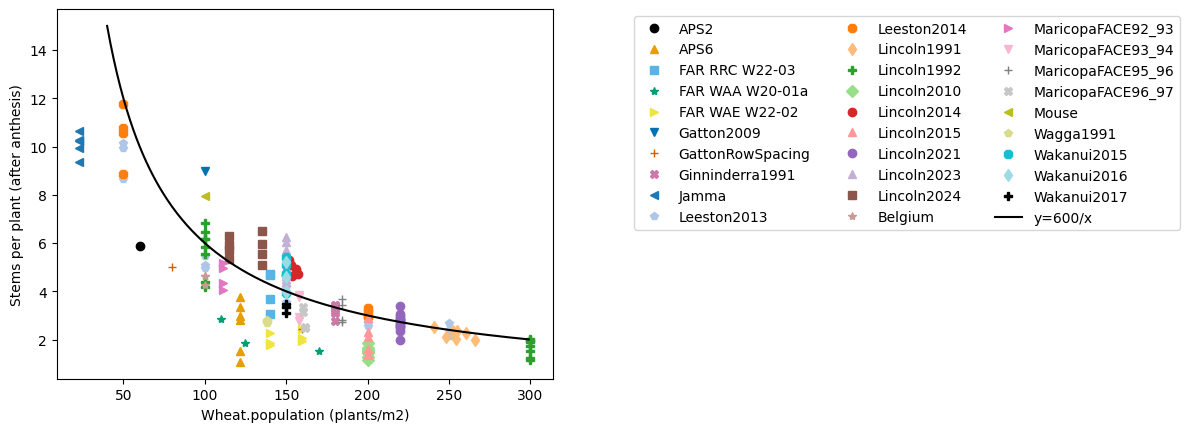

In [126]:
Experiments = list(MeanStemData.loc[:,'Experiment'].drop_duplicates())
cpos=1
mpos=1
for e in Experiments:
    plotData = MeanStemData.loc[MeanStemData.Experiment==e,:]
    plt.plot(plotData.loc[:,'Wheat.Population'],plotData.loc[:,'Wheat.Leaf.StemNumberPerPlant'],Markers[mpos],color=Colors[cpos],label=e)
    cpos+=1
    mpos+=1
    if mpos>16:
        mpos=1
    if cpos>28:
        cpos=1

xs = range(40,300)
ys = [600/(x+0) for x in xs]
plt.plot(xs,ys,'-',color='k',label='y=600/x')
plt.legend(bbox_to_anchor=(1.15, 1),numpoints=1,ncols=3)
plt.ylabel('Stems per plant (after anthesis)')
plt.xlabel('Wheat.population (plants/m2)')

(0.0, 1000.0)

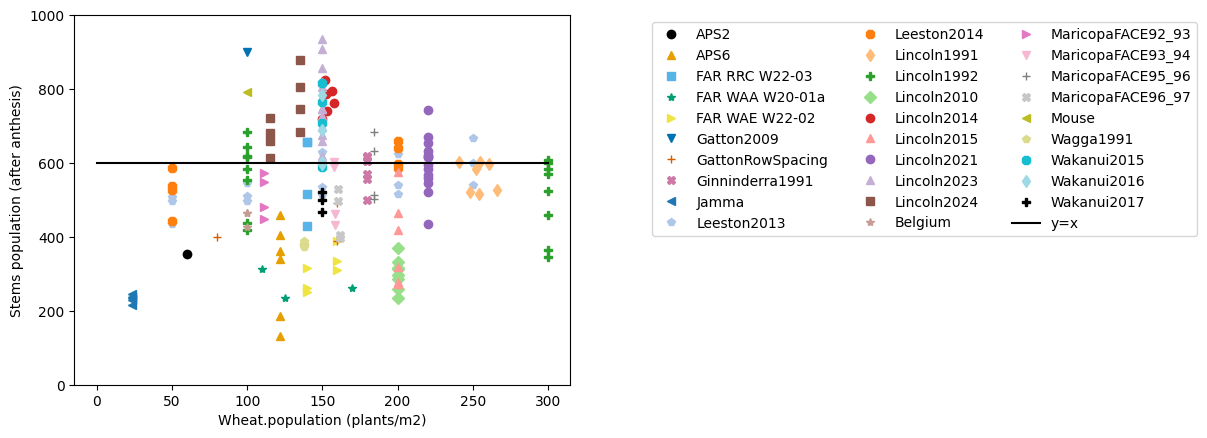

In [127]:
Experiments = list(MeanStemData.loc[:,'Experiment'].drop_duplicates())
cpos=1
mpos=1
for e in Experiments:
    plotData = MeanStemData.loc[MeanStemData.Experiment==e,:]
    plt.plot(plotData.loc[:,'Wheat.Population'],plotData.loc[:,'Wheat.Leaf.StemPopulation'],Markers[mpos],color=Colors[cpos],label=e)
    cpos+=1
    mpos+=1
    if mpos>16:
        mpos=1
    if cpos>28:
        cpos=1

xs = [0,300]
ys = [600,600]
plt.plot(xs,ys,'-',color='k',label='y=x')
plt.legend(bbox_to_anchor=(1.15, 1),numpoints=1,ncols=3)
plt.ylabel('Stems population (after anthesis)')
plt.xlabel('Wheat.population (plants/m2)')
plt.ylim(0,1000)

In [131]:
detailedStemData = ['APS2',
 'APS6',
 'GattonRowSpacing',
 'Ginninderra1991',
 'Lincoln1991',
 'Lincoln1992',
 'Lincoln2014',
 'Lincoln2015',
 'Lincoln2023',
 'Lincoln2024',
 'MaricopaFACE92_93',
 'MaricopaFACE93_94',
 'MaricopaFACE95_96',
 'MaricopaFACE96_97',
 'Wagga1991']

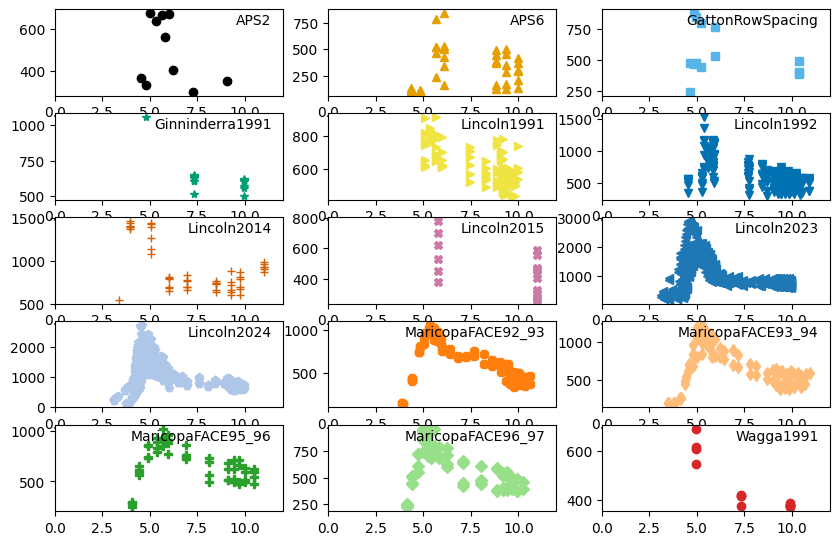

In [133]:
vars = ['Wheat.Leaf.StemPopulation','Wheat.Phenology.Stage','Wheat.Population','Wheat.Phenology.AccumulatedTT','Wheat.Leaf.StemNumberPerPlant']+['Experiment']
data = Observed.loc[:,vars].dropna(subset= ['Wheat.Leaf.StemPopulation','Wheat.Leaf.StemNumberPerPlant'],how='all')
cpos=1
mpos=1
pos=1
graph = plt.figure(figsize=(10,20))
for e in detailedStemData:
    ax = graph.add_subplot(15,3,pos)
    exData = data.loc[data.Experiment == e,:]
    sims = exData.index.get_level_values(0).drop_duplicates()
    spos = 0
    for s in sims:
    plt.plot(exData.loc[:,'Wheat.Phenology.Stage'],exData.loc[:,'Wheat.Leaf.StemPopulation'],Markers[mpos],color=Colors[cpos],label=e)
    plt.text(0.95,0.95,e,transform = ax.transAxes,horizontalalignment='right', verticalalignment='top')
    plt.xlim(0,12)
    cpos+=1
    mpos+=1
    pos+=1               
    if mpos>16:
        mpos=1
    if cpos>28:
        cpos=1